Importing libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pybammeis
import pybamm
from utils.load_data import get_exp_data
#from utils.parameters import params 
#params = params()
from utils.parameters_2 import graphite_exchange_current_density, nmc_exchange_current_density, electrolyte_conductivity, params_2
params = params_2()
from utils.potential_gradient import _dU_dc_anode, _dU_dc_cathode
from utils.check_SOC import get_vdc
from utils.convertion import dict_to_list, list_to_dict
from utils.ecm_randles import calc_randles_Z, a_randles
from utils.ecm_meyers import calc_meyers_Z, a_meyers
from utils.ecm_meyers_K import calc_meyers_K_Z, a_meyers_K
from utils.ecm_meyers_all_params import calc_meyers_all_Z, a_meyers_all
from utils.optimize import optimize_diff
from utils.optimize_from_Randles import optimize_randles 
from utils.optimizing_plot import optimizing_plot
from utils.changes_in_params_plot import plot_change_param
from utils.experimental_plot import plotting, combined_plot
from utils.all_sets_plot import plot_all_sets
from utils.pso import pso 
from utils.load_cycling_data import read_csv, read_txt
from utils.cycling_plot import plot_cycling
from utils.pybamm_plot import pybamm_plotting
from utils.Bode_plot import plot_impedance
from utils.geometry_params import T, R, F, n, c_e, c_n, volume_anode, area_electrode, i_0_a, e_a, r_a, c_p
from utils.R_ct import R_ct
from utils.pore_surface_area import a
from utils.meyers_initial_plot import plotting_meyers_initial


# Part 1: ECM

Comparing fitted ECM with the experimental data set 1 (zero degradation): 

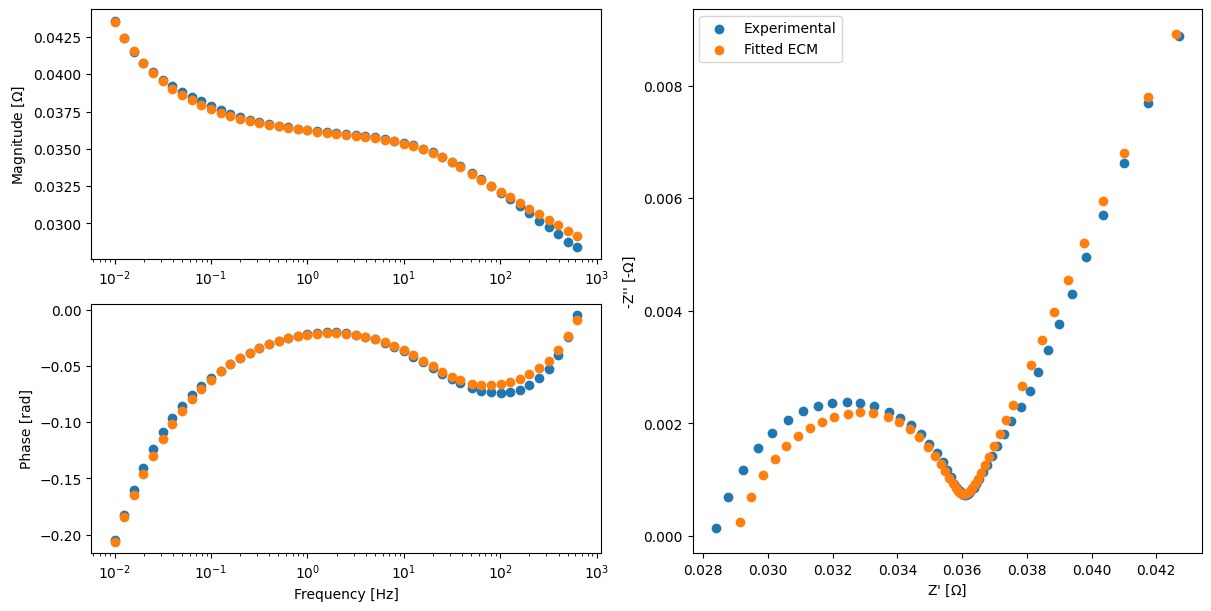

In [3]:
# The impedance for experimental data set 1
i = 1
freq = np.array(get_exp_data(i, "")[1])
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])
Z_exp = exp_real + exp_imag*1j

# The optimized Randles parameters
final_diff, opt_randles_param = optimize_diff(i, a_randles, calc_randles_Z)
Z_randles_opt = calc_randles_Z(opt_randles_param, freq)

# Plotting
plot_impedance([(freq, Z_exp), 
                (freq, Z_randles_opt)], ['Experimental', 'Fitted ECM'])

Plotting fitted ECM for all datasets:

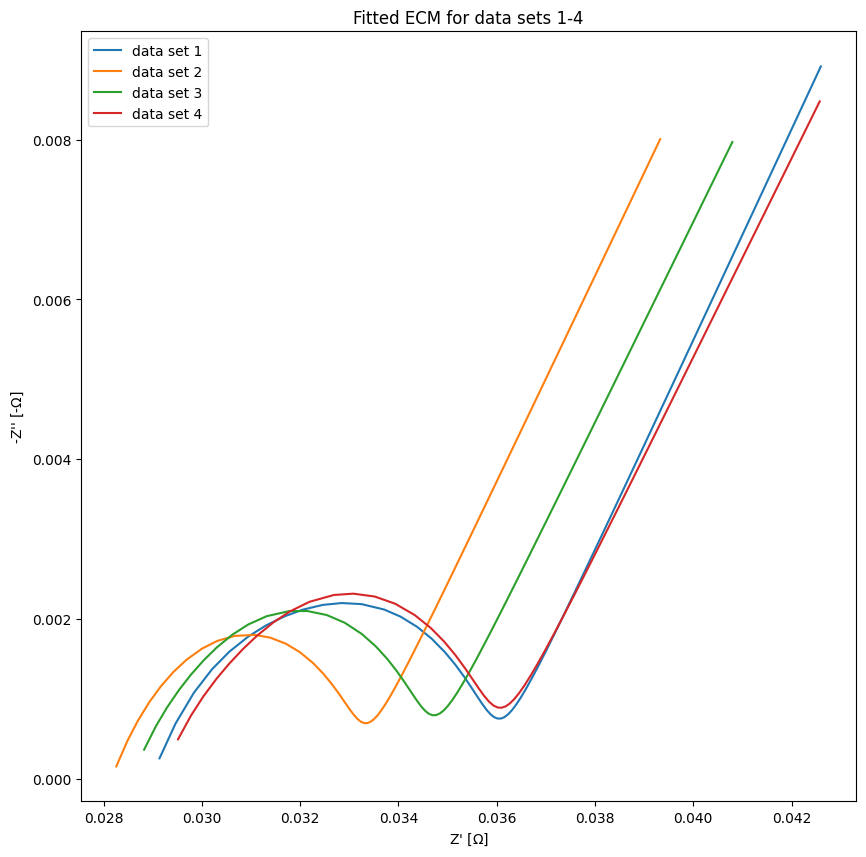

In [4]:
plot_all_sets('Fitted', a_randles, calc_randles_Z, optimize_diff)

# Part 2: PyBaMM

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method 

Using the same frequency range as the frequency range in the experimental data sets. 

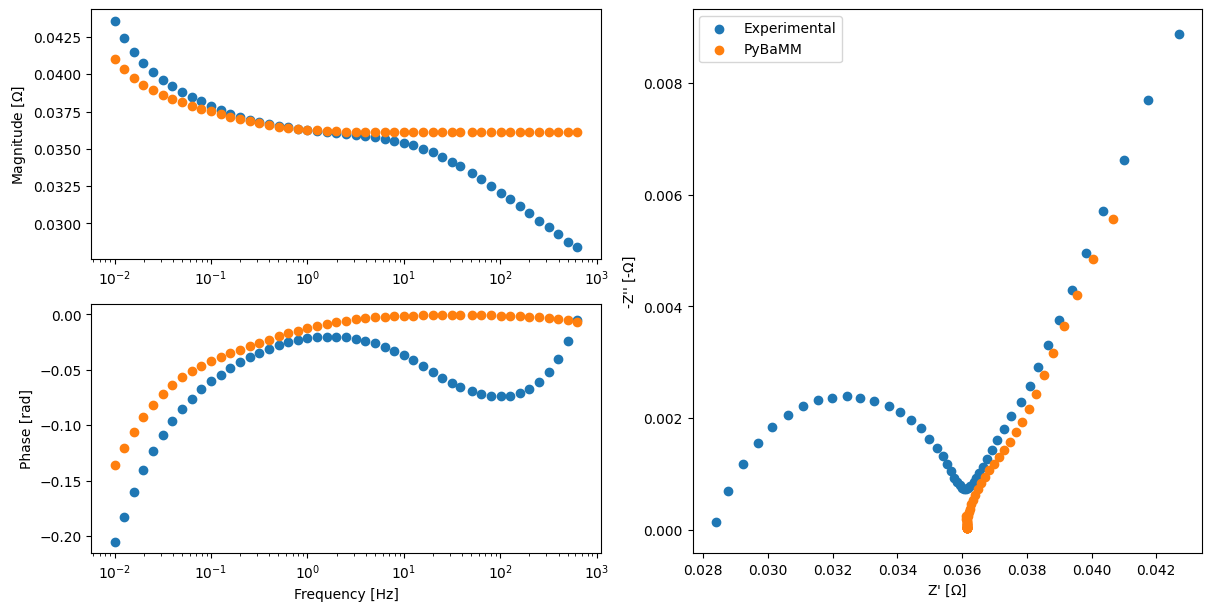

In [5]:
from utils.parameters_2 import params_2
params_pb = params_2()
from utils.pybamm_plot import set_SOC
set_SOC(params_pb, 0.45)
from utils.Z_pybamm import calc_pybamm_Z


Rel = .03
Z_pybamm_before = calc_pybamm_Z(1, params_pb, Rel)

plot_impedance([(freq, Z_exp), 
                (freq, Z_pybamm_before)
                ], ['Experimental', 'PyBaMM'])

As seen, the Pybamm simulation does not fit with the experimental graph. Further, I am finding the "correct" Pybamm parameters from the optimized Randles circuit!

#### Calculations

In [6]:
# The optimized Randles parameters
final_diff, opt_randles = optimize_diff(1, a_randles, calc_randles_Z)
opt_elems = list_to_dict(a_randles, opt_randles)

# geometry parameters
from utils.geometry_params import e_height, e_width, area_electrode, s_thick, anode_thick, cathode_thick, R, T, F, z


Electrolyte conductivity from Nernst-Einstein: 

$$ K = \frac{z^2F^2cD}{RT}, $$

where $D$ = diffusivity of ions in $[m^2s^{-1}]$. To express $D$ with the electrolyte resistance, $K$ is substituted by an expression derived from Ohms law: 

$$ K = \frac{L}{RA} $$

This gives that 

$$ D = \frac{TL}{z^2F^2cA}, $$ 

where $L$ = electrolyte "thickness" and $A$ = cross-sectional area of the electrolyte. 



In [7]:
print((T*s_thick)/(z**2*F**2*c_e*area_electrode))

# Parameters I want to change to optimize the simulation graph: 
params_pb_new = params_pb
params_pb_new.update({
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': opt_elems.get('Q2')/area_electrode, 
    'Positive electrode double-layer capacity [F.m-2]': opt_elems.get('Q1')/area_electrode, 

    #Exchange current density - relation to Rct in the Randles circuit through the Butler-Volmer 
    "Positive electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct1')), 
    "Negative electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct2')), 

    #Omic resistance - analog to Rel in the Randles circuit 
    "Electrolyte conductivity [S.m-1]": 1/(s_thick*opt_elems.get('R_el')), #function 

    # Diffusion coefficient - analog to W in the Randles circuit? 
    "Electrolyte diffusivity [m2.s-1]": (T*s_thick)/(z**2*F**2*c_e*area_electrode)
    #"Electrolyte diffusivity [m2.s-1]": (1/((opt_elems.get('A1')*area_electrode*z**2*F**2*np.sqrt(2)*c_e)/(R*T)))**2
    #"Negative particle diffusivity [m2.s-1]":,   
     })

5.336617369903008e-15


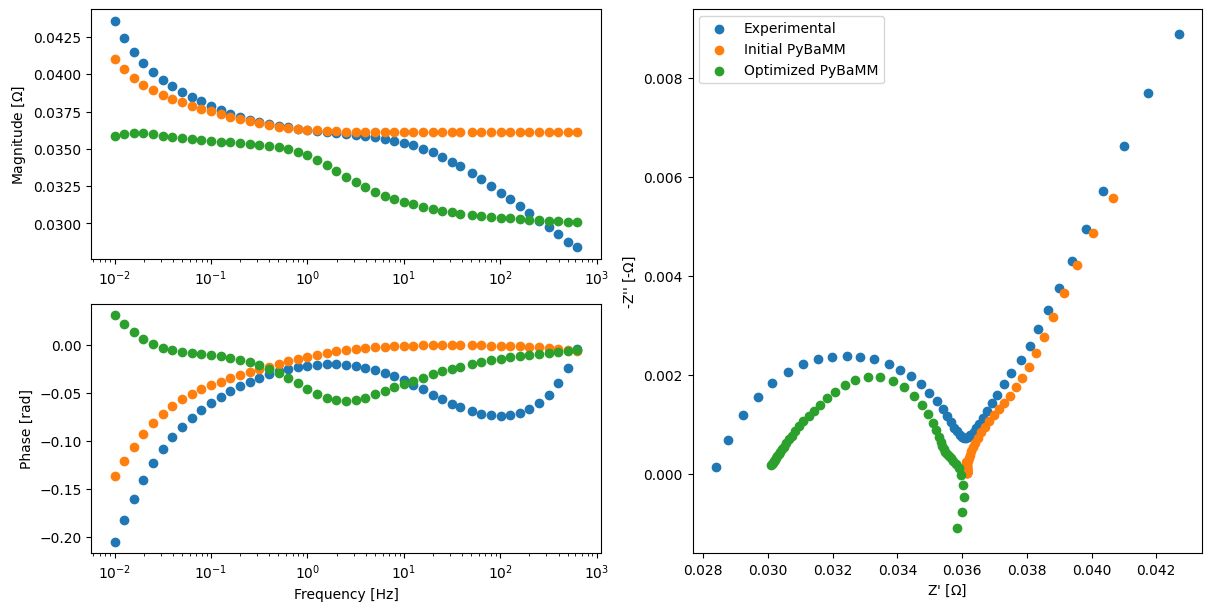

In [8]:

Z_pybamm_after = calc_pybamm_Z(1, params_pb, Rel)

plot_impedance([(freq, Z_exp), 
                (freq, Z_pybamm_before), 
                (freq, Z_pybamm_after)
                ], ['Experimental', 'Initial PyBaMM', 'Optimized PyBaMM'])

Jeg legger også på en elektrolyttresistans (under: 0.03 Ohm) for å flytte den simulerte grafen nærmere den eksperimentelle. 

# Part 3: Meyers model

$$R_{part} = \left(-\frac{\partial U}{\partial c_s}\right)\frac{R_s}{FD_s}$$

$$Y_s = \frac{\sqrt{j\Omega_s}-\tanh(\sqrt{j\Omega_s})}{\tanh(\sqrt{j\Omega_s})},$$

where $Y_s$ is the admittance for the diffusion effect and $\Omega_s$ is the dimensionless frequency: 

$$\Omega_s = \frac{\omega R_s^2}{D_s\eta}$$

Further, 

$$Y(\omega) = \frac{1}{\frac{R1 + \frac{R_{part}}{Y_s}}{1 + j\omega C1\left(R1 + \frac{R_{part}}{Y_s}\right)} + \frac{R2}{1+j\omega R2\cdot C2}}, $$

where $Y(\omega)$ is the admittance (intercalation, BV-kinetics and double-layer capacitance) of a single particle at a given frequency. $\overline{aY}$ is the average admittance in the porous electrode. 

$$v = \frac{L}{\left(\frac{K\sigma}{K + \sigma}\right)^{\frac{1}{2}}\left({\overline{aY}}\right)^{-\frac{1}{2}}}, $$

where the parameter $v$ is a function of frequency $\omega$ and is determined for set values of $\sigma$ and $K$. 
Finally, the total impedance is given by

$$Z = \frac{L}{K+\sigma}\left[1 + \frac{2 + (\frac{\sigma}{K} + \frac{K}{\sigma})\cosh v}{v\cdot \sinh v}\right]$$




### Meyers parameters

+ $R1$ - resistance 
+ $R2$ - resistance 
+ $C1$ - capicitance 
+ $C2$ - capicitance 
+ $R_s$ - particle size (assuming radius)
+ $D_s$ - diffusion coefficient 
+ $a$ - surface area of pores per volume electrode
+ $L$ - electrode thickness
+ $K$ - electrolyte conductivity 
+ $\sigma$ - electrode conductivity 
+ $\epsilon$ - porosity 
+ $\left(-\frac{\partial U}{\partial c_s}\right)$

These parameters are defined from the given parameters by Amund (in the utils folder: parameters). If the Meyer parameter does not have an equivalent in the parameter list above, it is calculated from relations (for example, the resistances $R1$ and $R2$ are calculated from the exhange current density $i$). 


### Calculating the Meyers parameters which are not defined in the given parameter lists:


The charge transfer resistances (= $R_{ct}$), $R1$ and $R2$, are found from the Butler-Volmer equation: 

$$R_{ct} = \frac{RT}{n\cdot i_0(\alpha_a + \alpha_c)F}, $$

at small overpotentials and assuming a symmetrical charge transfer process $(\alpha_a + \alpha_c = 1)$. This equation is also written as equation $(20)$ in the Meyers paper. 

In [9]:

R1_a = R_ct(i_0_a)
print(R1_a)


0.00039253617953707626


####  Equation for finding the pore surface volume divided by the electrode volume (=$a$):

The pore surface area can be found from the following calculations: 

$$V_{particle} = \frac{4\pi r^3}{3}$$
$$V_{active} = \epsilon \cdot V_{electrode}, $$

where $\epsilon$ is the fraction of active electrode material and then $V_{active}$ is the volume of the active electrode material. This gives the number of particles $N = \frac{V_{active}}{V_{particle}}$. Further, the surface area of one particle is 

$$A_{particle} = 4 \pi r^2, $$

so that $A_{total} = N\cdot A_{particle}$, where $A_{total}$ is the total pore/particle surface area. 

Then $a$ is calculated from 

$$a = \frac{A_{total}}{V_{electrode}}$$




In [10]:
area_pore = a(volume_anode, e_a)

### The resulting Meyers parameter set 

For just the anode (R2 and C2 are not included)

In [12]:
e_s = params['Negative electrode porosity']

# Meyers component parameters
a_meyers_initial = {
    "Rel": 0.003, # motstand elektrolytt, [ohm.m^2] 
    "R1": R1_a, 
    "C1": params['Negative electrode double-layer capacity [F.m-2]'],
    "Rs": params['Negative particle radius [m]'], 
    #"Ds": params['Negative electrode diffusivity [m2.s-1]'],
    "Ds": params['Electrolyte diffusivity [m2.s-1]'](c_e, T),
    "a": a(volume_anode, e_a),  
    "L": params['Negative electrode thickness [m]'],  
    "K" : (params['Electrolyte conductivity [S.m-1]'](c_e, T)*e_s)/params['Negative electrode Bruggeman coefficient (electrolyte)'],  # ledningsevne elektrolytt [S.m^-1]
    "sigma": params['Negative electrode conductivity [S.m-1]'], 
    "ebsilon": e_a,     
    "-dU_dcs": _dU_dc_anode(c_n), 
    }
print(a_meyers_initial)


{'Rel': 0.003, 'R1': 0.00039253617953707626, 'C1': 0.2, 'Rs': 6.1e-06, 'Ds': 1.7694000000000006e-10, 'a': 385573.7704918033, 'L': 8.67e-05, 'K': 0.13661280000000006, 'sigma': 100.0, 'ebsilon': 0.784, '-dU_dcs': 8.600614595301764e-06}


# Dataset 1: Fitting parameters to experimental data

In general, R1, R2, C1, C2, Ds and a are the parameters which will be fitted. The rest of the Meyers parameters are assumed correct and constant. 
The changes are done in the following parameter sets: 
+ "a_meyers": An electrolyte resistance is added to move the simulated plot to the experimental 
+ "a_meyers_K": The electrolyte konductivity is also added
+ "a_meyers_all": All parameters are optimized, plus an inductance term to modify the semicircle. 

Since the scipy optimization works on the Randles ECM (and not on the Meyers ECM), I have suspected that the Meyers model does not properly fit the experimental data. To investigate this, I made a new optimization code named "optimize_randles", which optimizes the meyers parameters to the optimized Randles graph (since the optimized Randles graph is smoother than the experimental data)! As seen in the difference between the last and the above last plot below, my suspicions were true, as interpreted by the shape of the scipy optmized graph in green. 

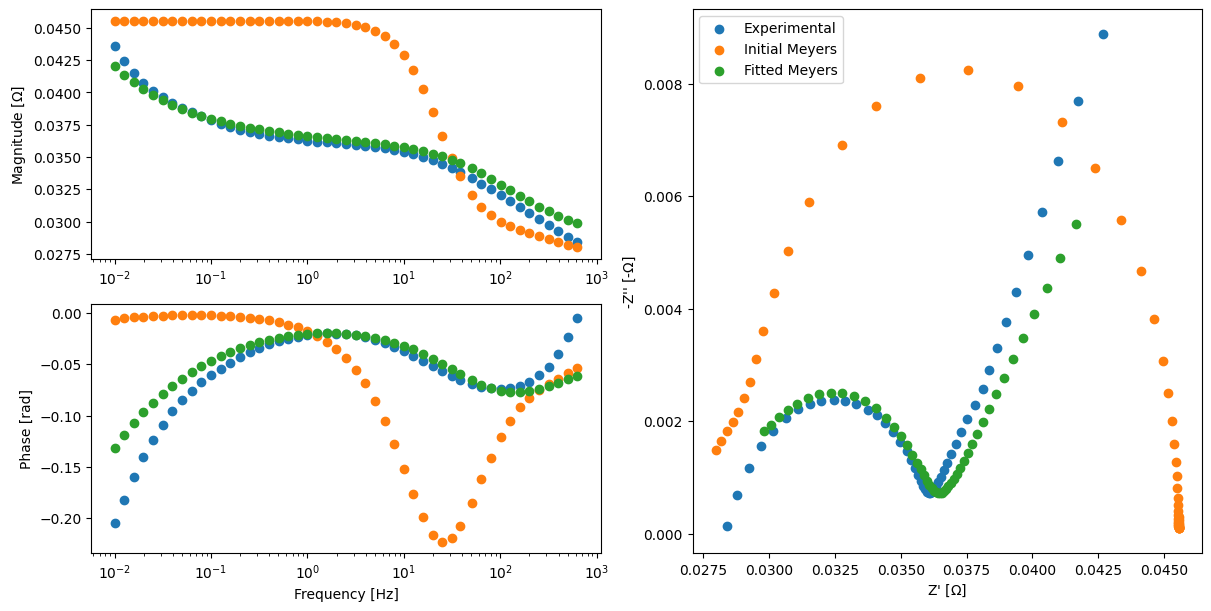

In [16]:
from utils.meyers_initial_plot import calc_meyers_initial_Z, a_meyers_initial
from utils.ecm_meyers import calc_meyers_Z, a_meyers

# The initial Meyers parameters
Z_meyers_initial = calc_meyers_initial_Z(dict_to_list(a_meyers_initial), freq)

# The optimized Meyers parameters
final_diff, list_meyers = optimize_diff(1, a_meyers, calc_meyers_Z)
opt_dict = list_to_dict(a_meyers, list_meyers)

# Plotting
Z_meyers_opt = calc_meyers_Z(list_meyers, freq)
plot_impedance([(freq, Z_exp), 
                (freq, Z_meyers_initial),
                (freq, Z_meyers_opt)], ['Experimental', 'Initial Meyers', 'Fitted Meyers'])


# Part 4: Extra

#### We can also observe how a given parameter changes for each data set (degradation step)

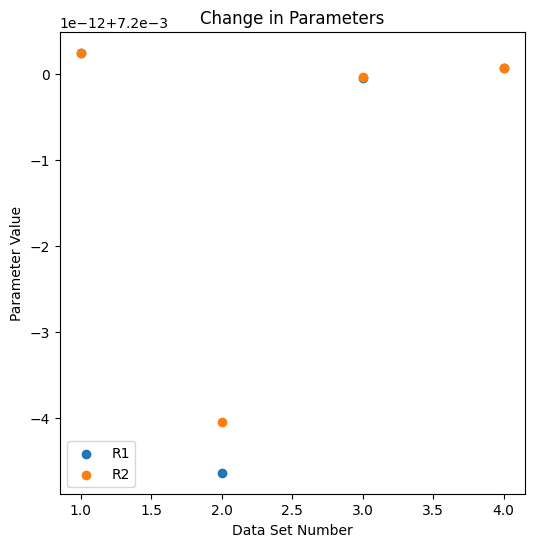

In [13]:

plot_change_param(['R1', 'R2'], a_meyers_all, calc_meyers_all_Z, optimize_randles)

## Plotting the C/5 cycling data to confirm amount of degradation

$ R = \frac{\Delta U}{\Delta I}$ in the cycling plot, which should correspond to the amount of change in resistance in the Nyquist plots. 

In [14]:
MJ12s = {
    "MJ12_01": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_01.015.txt'), 
    "MJ12_02": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_02.016.txt'),
    "MJ12_03": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_03 - 010.csv'), 
    "MJ12_04": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_04 - 010.csv'), 
    "MJ12_05": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_05 - 016.csv')
}

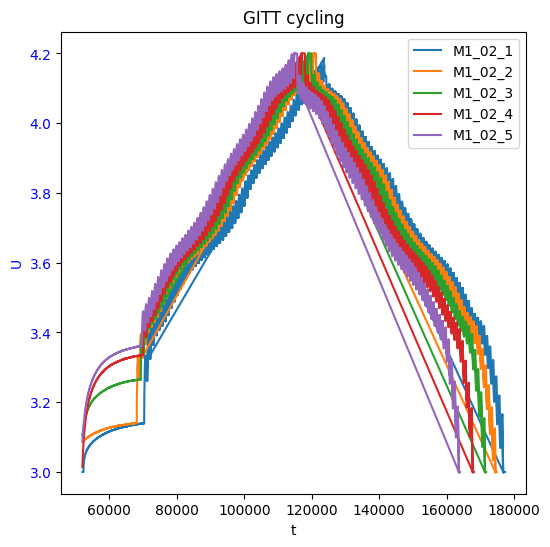

the increase in resistance from data set 1 to 2, and 2 to 3 etc., is [0.10436137071651047, 0.004672897196261859, 0.02024922118380047, 0.04672897196261721]


In [15]:
plot_cycling(dict_to_list(MJ12s))

Here, I have used the GITT charging cycle where the first data set is at $45 \%$ SOC, namely $U = 3.587 V$. 
Then I have calculated $R_{change} = \frac{\Delta U}{I}$ since we have a constant current! 

### Comparing for all simulations and experimental 

In [16]:


i = 1
freq = np.array(get_exp_data(i, "")[1])
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])

Z_exp = exp_real + exp_imag*1j

final_diff, opt_randles_param = optimize_diff(i, a_randles, calc_randles_Z)
Z_randles_opt = calc_randles_Z(opt_randles_param, freq)

model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
eis_sim_func = pybammeis.EISSimulation(model, parameter_values=params_pb)
sim_f_func = eis_sim_func.solve(freq, method = "prebicgstab")
Rel = 0.030
Z_pybamm = (sim_f_func.real + Rel) + sim_f_func.imag*1j

plot_impedance([(freq, Z_randles_opt), 
                (freq, calc_meyers_all_Z(dict_to_list(a_meyers_all), freq)),
                (freq, Z_exp), 
                (freq, Z_pybamm)
                ])

TypeError: plot_impedance() missing 1 required positional argument: 'names'